In [1]:
install.packages("GGally")
library(tidyverse)
library(tidymodels)
library(patchwork)
library(GGally)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

## Title 

### Chest Pain Classification Using KNN

## Introduction 

### Background Information:
Heart disease refers to a range of conditions that affect the heart. Various factors, such as age, lifestyle, and genetics, can influence the chances of an individual getting heart disease. We want to understand what factors are related to certain chest pain types.

The KNN algorithim works as follows, based on the K (this can be any number eg: 1,2,3) nearest neighbors, we will take the classification of them and say this observation is of that classification. We use proximity to make classifications or predictions about the grouping of an individual data point.

Example: If a certain observation has an unknown classification and it's K nearest neighbors are all of type "Burger" then this observation will be of type burger!

### The Question:
Can we determine what type of chest pain a patient is likely experiencing based on only their age and cholesterol levels?

### Dataset:
The dataset that we will be using is titled “Heart Disease”.  It contains observations from various locations published as 4 experiment databases, each including the same subset of 14 attributes. For ease of reading, we chose to use the processed experiment files for our data.


## Methods & Results

### Pre Analysis:

To read the data, we first downloaded the data set. We then looked through the files and realized that only the processed data was likely to be readable with our current knowledge, and thus chose to use the 4 processed files.
<br>

After reading the files and looking through the heart-disease.names file for the descriptions of each attribute, we gave the table columns appropriate names to ensure the data would be understandable.
Below is the original data with added column names:

In [2]:
hungarian_data <- read_delim("https://raw.githubusercontent.com/blu-01/DSCI-100-003-Group-21/main/proposal%20rough%20work/processed.hungarian.data", delim = ",", col_names = FALSE)
colnames(hungarian_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

cleveland_data <- read_delim("https://raw.githubusercontent.com/blu-01/DSCI-100-003-Group-21/main/proposal%20rough%20work/processed.cleveland.data", delim = ",", col_names = FALSE)
colnames(cleveland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

switzerland_data <- read_delim("https://raw.githubusercontent.com/blu-01/DSCI-100-003-Group-21/main/proposal%20rough%20work/processed.switzerland.data", delim = ",", col_names = FALSE)
colnames(switzerland_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

va_data <- read_delim("https://raw.githubusercontent.com/blu-01/DSCI-100-003-Group-21/main/proposal%20rough%20work/processed.va.data", delim = ",", col_names = FALSE)
colnames(va_data) <- c("age", "sex", "chest_pain_type", "rest_bp", "serum_cholesterol", "fasting_bs", "rest_ecg_results",
                             "max_heartrate", "exercise_angina", "st_depression", "slope_type", "num_coloured_flourosopy", "thal", "diagnosis")

stacked_data <- rbind(hungarian_data, va_data, switzerland_data, cleveland_data)
head(stacked_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,slope_type,num_coloured_flourosopy,thal,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


After giving the data the correct columns, we stacked the data together to make the analyzation process easier. The next step in tidying the data was to give values within each observation the appropriate category, and to remove all NA values.

In [3]:
editedData <- stacked_data

idx <- editedData == "?"
# replace "?" values with NA
is.na(editedData) <- idx

navalues <- colSums(is.na(editedData))
navalues

age                     sex         chest_pain_type 
                      0                       0                       0 
                rest_bp       serum_cholesterol              fasting_bs 
                     59                      30                      90 
       rest_ecg_results           max_heartrate         exercise_angina 
                      2                      55                      55 
          st_depression              slope_type num_coloured_flourosopy 
                     62                     309                     611 
                   thal               diagnosis 
                    486                       0

From this summary, it was clear that there were too many NA values for slope type, flourosopy, and thal. We decided to cut these columns from the data and then remove the remaining NA values.

In [ ]:
#Removing columns with too many NA values and then removing observations with NA
editedData <- editedData |>
    select(-slope_type, -num_coloured_flourosopy, -thal) |>
    na.omit()

We then gave the different factors descriptive names to replace their previous numeric values.

In [19]:
for(i in 1:nrow(editedData)) {       # for-loop over rows
    if(editedData$sex[i] == 1){
      editedData$sex[i] <- "Male"
    }else{
      editedData$sex[i]<- "Female"
      }
    
    if(editedData$chest_pain_type[i] == 1){
      editedData$chest_pain_type[i] <- "Typical Angina"
    }

    if(editedData$chest_pain_type[i] == 2){
      editedData$chest_pain_type[i] <- "Atypical Angina"
    }

    if(editedData$chest_pain_type[i] == 3){
      editedData$chest_pain_type[i] <- "Non-Anginal Pain"
    }

    if(editedData$chest_pain_type[i] == 4){
      editedData$chest_pain_type[i] <- "Asymptomatic"
    }

   if(editedData$diagnosis[i] == 0){
     editedData$diagnosis[i] <- "< 50% Diameter Narrowing"
   }else{
     editedData$diagnosis[i] <- "> 50% Diameter Narrowing"
   }  

    if(!is.na(editedData$rest_ecg_results[i])){
       if(editedData$rest_ecg_results[i] == 0){
          editedData$rest_ecg_results[i] <- "Normal"
             }
    
        if(editedData$rest_ecg_results[i] == 1){
          editedData$rest_ecg_results[i] <- "ST-T Wave Abnormality"
             }
    
         if(editedData$rest_ecg_results[i] == 2){
          editedData$rest_ecg_results[i] <- "Probable or Definite Left Ventricular Hypertrophy"
             }
        
        }

 if(!is.na(editedData$fasting_bs[i])){

    if(editedData$fasting_bs[i] == 0){
          editedData$fasting_bs[i] <- "False"
             }
    
    if(editedData$fasting_bs[i] == 1){
          editedData$fasting_bs[i] <- "True"
             }
     }

    
     if(!is.na(editedData$exercise_angina[i])){
        if(editedData$exercise_angina[i] == 0){
              editedData$exercise_angina[i] <- "No"
                 }
        
        if(editedData$exercise_angina[i] == 1){
              editedData$exercise_angina[i] <- "Yes"
                 }
         }

}
#Removing incorrect 0 values
 editedData <- editedData |>
    filter(age != 0) |>
    filter(rest_bp != 0) |>
    filter(serum_cholesterol != 0) |>
    filter(max_heartrate != 0)
#Changing data types
editedData <- editedData |>
    mutate(sex = as.factor(sex)) |>
    mutate(chest_pain_type = as.factor(chest_pain_type)) |>
    mutate(rest_bp = as.numeric(rest_bp)) |>
    mutate(serum_cholesterol = as.numeric(serum_cholesterol)) |>
    mutate(fasting_bs = as.factor(fasting_bs)) |>
    mutate(rest_ecg_results = as.factor(rest_ecg_results)) |>
    mutate(max_heartrate = as.numeric(max_heartrate)) |>
    mutate(exercise_angina = as.factor(exercise_angina)) |>
    mutate(st_depression = as.numeric(st_depression)) |>
    mutate(diagnosis = as.factor(diagnosis))
head(editedData)

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `slope_type` doesn't exist.


In [6]:
#Removing incorrect 0 values
editedData <- editedData |>
    filter(age != 0) |>
    filter(rest_bp != 0) |>
    filter(serum_cholesterol != 0) |>
    filter(max_heartrate != 0)

We also noticed peaks in the distribution of our predictors at 0, which was clearly wrong, so we decided to remove observations with these incorrect 0 values.

In [7]:
#Changing data types
editedData <- editedData |>
    mutate(sex = as.factor(sex)) |>
    mutate(chest_pain_type = as.factor(chest_pain_type)) |>
    mutate(rest_bp = as.numeric(rest_bp)) |>
    mutate(fasting_bs = as.factor(fasting_bs)) |>
    mutate(rest_ecg_results = as.factor(rest_ecg_results)) |>
    mutate(max_heartrate = as.numeric(max_heartrate)) |>
    mutate(exercise_angina = as.factor(exercise_angina)) |>
    mutate(st_depression = as.numeric(st_depression)) |>
    mutate(diagnosis = as.factor(diagnosis))

Finally, we corrected the data types for the different columns.

After these methods, we are left with this data!

Here is a sample of our data below which also marks the end of our tidying.

In [8]:
head(editedData)

age,sex,chest_pain_type,rest_bp,serum_cholesterol,fasting_bs,rest_ecg_results,max_heartrate,exercise_angina,st_depression,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>
28,Male,Atypical Angina,130,132,False,Probable or Definite Left Ventricular Hypertrophy,185,No,0,< 50% Diameter Narrowing
29,Male,Atypical Angina,120,243,False,Normal,160,No,0,< 50% Diameter Narrowing
30,Female,Typical Angina,170,237,False,ST-T Wave Abnormality,170,No,0,< 50% Diameter Narrowing
31,Female,Atypical Angina,100,219,False,ST-T Wave Abnormality,150,No,0,< 50% Diameter Narrowing
32,Female,Atypical Angina,105,198,False,Normal,165,No,0,< 50% Diameter Narrowing
32,Male,Atypical Angina,110,225,False,Normal,184,No,0,< 50% Diameter Narrowing


We made visualizations like these for all of the predictors in the preliminary analysis, but for the sake of space, we have kept only the ones relevant to later sections.

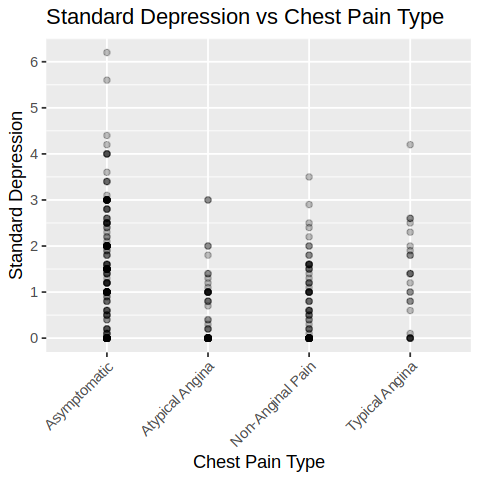

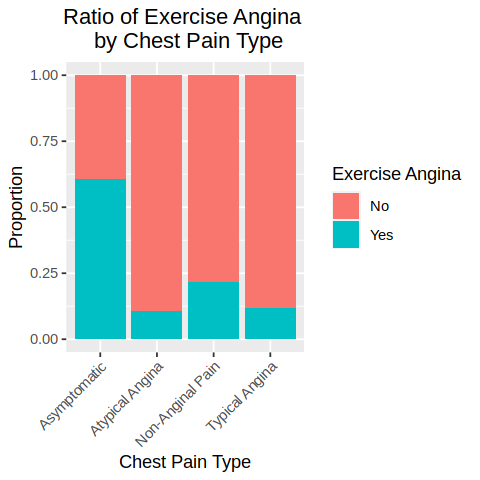

In [40]:
options(repr.plot.height = 4, repr.plot.width = 4)

PainVsDepression <- data_train |> 
    ggplot(aes(x = chest_pain_type, y = st_depression)) + 
    geom_point(alpha = 0.25) + 
    labs(x= "Chest Pain Type", title="Standard Depression vs Chest Pain Type") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    scale_y_continuous("Standard Depression", breaks = seq(0, 10, by = 1)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

PainVsRestECG <- data_train |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = rest_ecg_results)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of Resting \n ECG Measurements \n by Chest Pain Type", fill = "Resting ECG Measurement")

PainVsExerciseAngina <- data_train |>
    na.omit() |>
    ggplot(aes(x = chest_pain_type, fill = exercise_angina)) +
    geom_bar(position = "fill") +
    scale_x_discrete(labels = c("Asymptomatic", "Atypical Angina", "Non-Anginal Pain", "Typical Angina")) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), plot.title = element_text(hjust = 0.5)) +    
    labs(x= "Chest Pain Type", y = "Proportion", title="Ratio of Exercise Angina \n by Chest Pain Type", fill = "Exercise Angina")

PainVsDepression
PainVsExerciseAngina

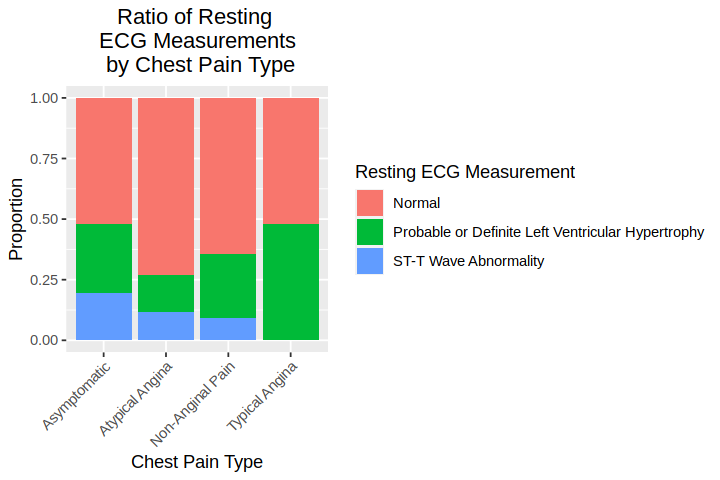

In [43]:
options(repr.plot.height = 4, repr.plot.width = 6)
PainVsRestECG

We created these visualizations to see the distribution of different values depending on chest pain type for each predictor. The implication of these visualizations will be discussed in the next section.

### Analysis Methods:

In our analysis, we will use all of the remaining factors as our predictors. We chose age, sex, blood pressure, cholesterol, and blood sugar as they were designated as major risk factors by a study on risk factors for cardiovascular disease$^1$, with blood pressure and cholesterol in particular being emphasized by the CDC$^2$. An article by Harvard$^3$ also states "Several large observational studies have indicated that a high aerobic capacity is associated with a lower risk of heart attack and death," with "maximum heart rate play\[ing\] a major role in setting your aerobic capacity." Finally, for standard depression, exercise angina and resting ECG measurements, our preliminary visualizations showed noticable distinctions between different types of chest pains in terms of the distribution of values, and so we decided these values would likely be useful for grouping neighbors.
<br>

For our final visualization, we plan on creating a scatterplot showing \<explain scatterplot here\>. The shape and colour of each point will correspond to its chest pain type, and we can visualize new observations across the multiple grids to see if our predictors do a good job of evaluating the likely class of the new observation. 

### Implementation Of Analysis Methods:

In [9]:
set.seed(100)

data_split <- initial_split(editedData, prop = 0.75, strata = chest_pain_type)
data_train <- training(data_split)
data_test <- testing(data_split) 

We first created our training/testing split with a proportion of 0.75, matching much of the work we did in class.

In [28]:
set.seed(100)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_recipe <- recipe(chest_pain_type ~ .,
                       data = data_train) |>
    step_scale(age, serum_cholesterol, rest_bp, max_heartrate, st_depression) |>
    step_center(age, serum_cholesterol, rest_bp, max_heartrate, st_depression)

heart_refold <- vfold_cv(data_train, v = 5, strata = chest_pain_type)

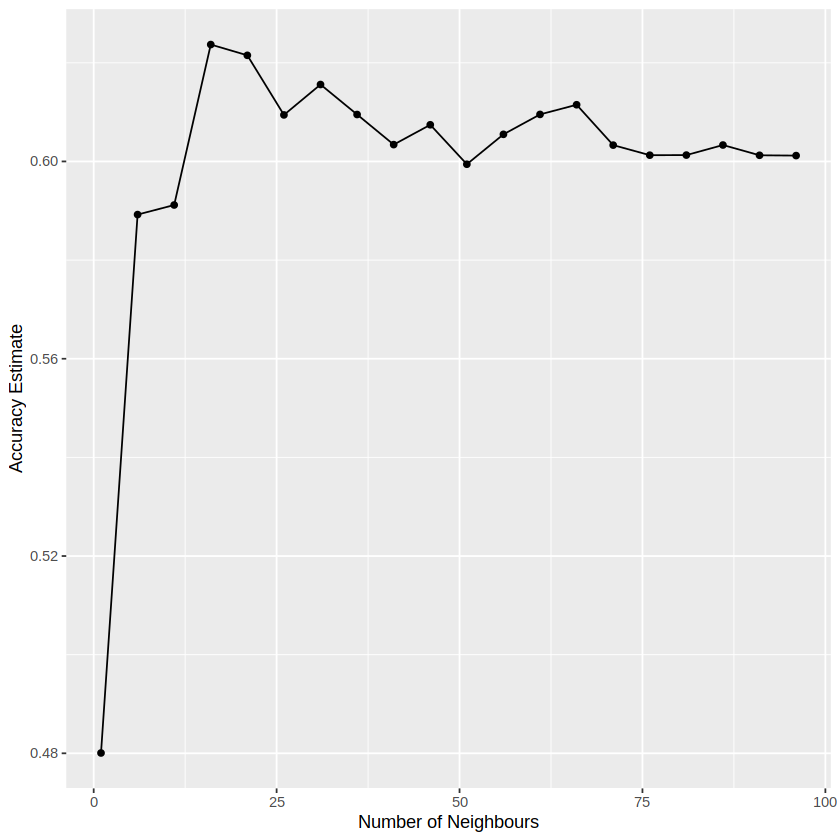

In [21]:
set.seed(100)

k_vals_wide <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

resample_results_wide <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_refold, grid = k_vals_wide) |>
    collect_metrics()

cross_val_plot_wide <- resample_results_wide |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate")

cross_val_plot_wide

We first plotted accuracy against a wide range of neighbor values to see which range we should look into to find the optimal neighbor count. From this chart, we decided to look more closely at the peak range of neighbors.

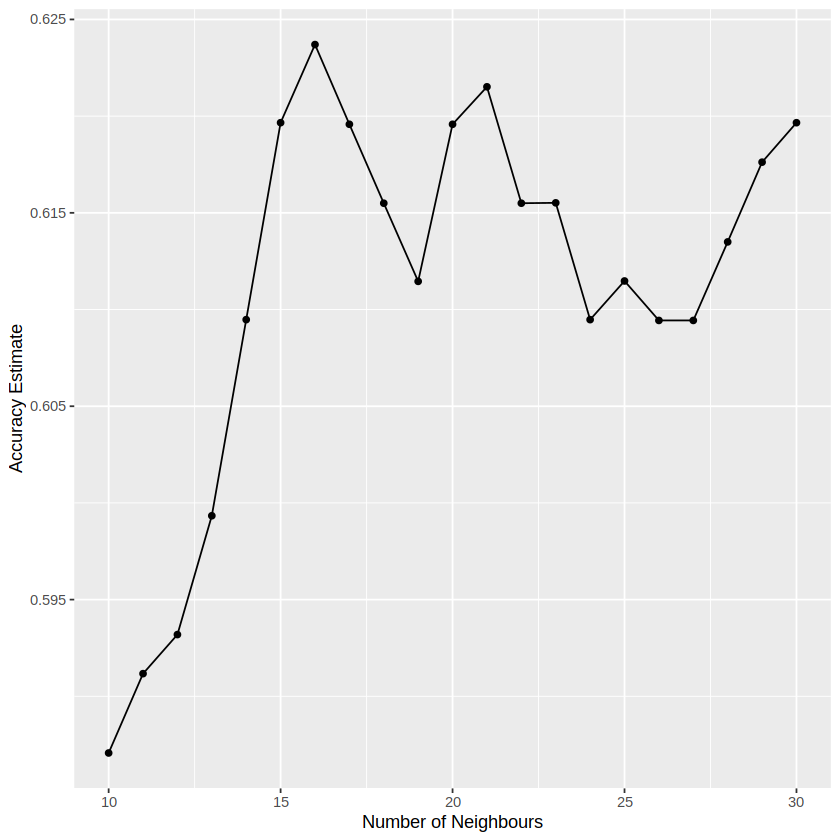

In [24]:
set.seed(100)

k_vals <- tibble(neighbors = seq(from = 10, to = 30, by = 1))

resample_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_refold, grid = k_vals) |>
    collect_metrics()

best_neighbors <- resample_results |>
    filter(.metric == "accuracy") |>
    slice_max(mean) |>
    pull(neighbors)

cross_val_plot <- resample_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate")
cross_val_plot

In [25]:
best_neighbors

[1] 16

The highest accuracy value for neighbors was when n = 16. However, we decided to go with n = 21 as it matched the 3 criteria for selecting a good K value:
- High accuracy (relatively speaking)
- High accuracy neighbors
- Not too computationally expensive

On the other hand, there was a clear steep drop off in accuracy on the lower end of n = 16 and so our faith that it was the best choice was not as high.

In [26]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data_train)

pain_predictions <- predict(heart_fit, data_test) |>
    bind_cols(data_test)
pain_prediction_accuracy <- pain_predictions |>
    metrics(truth = chest_pain_type, estimate = .pred_class)
pain_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5808383
kap,multiclass,0.3320000


In [27]:
pain_matrix <- pain_predictions |>
    conf_mat(truth = chest_pain_type, estimate = .pred_class)
pain_matrix

                  Truth
Prediction         Asymptomatic Atypical Angina Non-Anginal Pain Typical Angina
  Asymptomatic               66               8               13              4
  Atypical Angina            17              26               19              5
  Non-Anginal Pain            1               2                5              1
  Typical Angina              0               0                0              0

The accuracy of our model is about 58% when run on the testing data. Given that there are 4 classes, the accuracy for random guessing would be around 25%, meaning the predictors we have trained our model on are definitely correlated in some way to each of the chest pain types. However, an accuracy of little under 60% is still far from ideal, and if we wanted to implement this model in a real world scenario, we would likely need to give it more predictors or use a more advanced method of modeling than k-nearest neighbors. From the confusion matrix, it is notable that the least accurate prediction class by far is for Non-Anginal Pain, which is when the patient has chest pain not caused by heart disease. However, we are not exactly sure about the implications of this finding, as we do not know how important false positives or negatives are for these different chest pain types.

### Visualization Of Analysis:

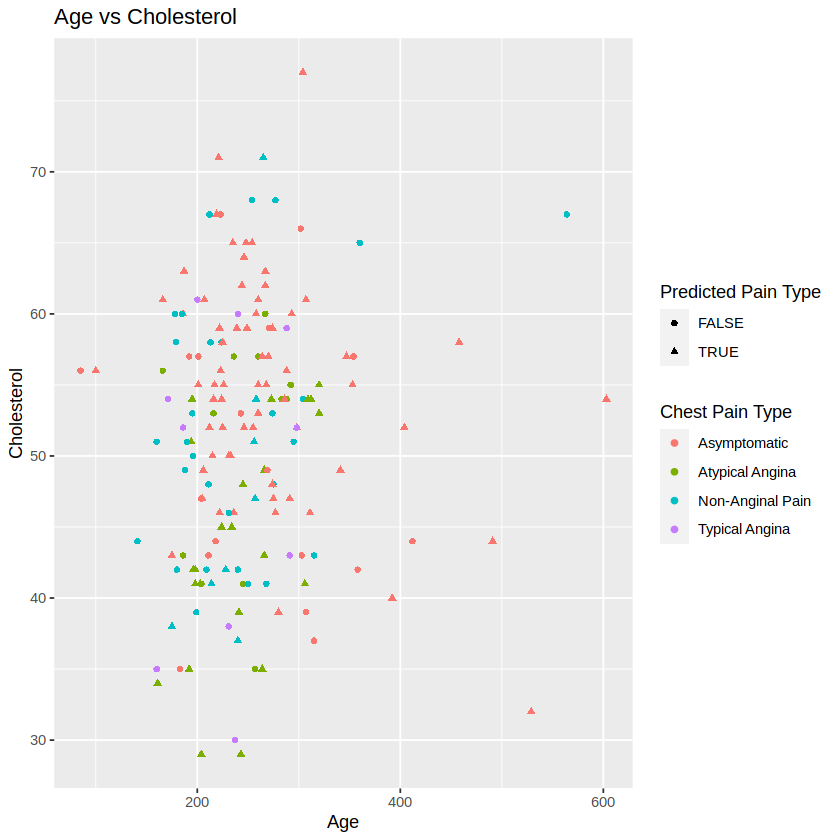

In [16]:
pain_predictions <- pain_predictions |> mutate(true = chest_pain_type == .pred_class)

plotagechlo <- pain_predictions |> ggplot(aes(x = serum_cholesterol, y = age, color = chest_pain_type, shape = true)) + geom_point() + labs(x = "Age", y = "Cholesterol", color = "Chest Pain Type", shape = "Predicted Pain Type", title = "Age vs Cholesterol") 

plotagechlo

In the graph above, we are trying to see if the predicted type matches the actual type. The goal of this graph is to show our trained model and test it against our real data.

We chose to use Cholesterol and Age since these are the most common causes predictors of heart disease as noted by Risk Factors for Coronary Artery Disease: Historical Perspectives which led us to choose these two quantitative data columns for our plot.

Right now we know that the accuracy of our trained data is around 57% which is why our False and True shapes are of similar count.

## Discussion

### What We Found:

We found that with our analysis, our accuracy is around 57% which is not very profound but it proves to be better than randomly guessing what a possible observation means.

### Is This What We Expected:

### Impact Of Findings:

### Future Questions:

## References

1. [Risk Factors for Coronary Artery Disease: Historical Perspectives](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5686931/), Rachel Hajar, July, 2017 

2. [Heart Disease and Stroke](https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity.), Centers for Disease Control and Prevention, September, 2022 

3. [What is a normal heart rate?](https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you), Howard LeWine, June, 2023